# ***Tech Challenge - Fase 2***

## **Grupo 38**


Leadnro Braga Alves

Rodrigo Mitsuo Yoshida

Roberto Yukio Ihara

## O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base. Para isso utilize a base de dados contida no site da investing e selecione o período “diário”, com o intervalo de tempo que achar adequado. Você precisará demonstrar para o time de investimentos:
- O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
- Justificar a técnica utilizada;
- Atingir uma acuracidade adequada (acima de 70%).

## Análise Exploratória dos Dados

Bibliotecas

In [278]:
import pandas as pd
import numpy as np 
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from dateutil.relativedelta import relativedelta
import streamlit as st

#from statsforecast import StatsForecast
#from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

Vamos utilizar o yfinance que é uma biblioteca do Python que permite a extração e análise de dados financeiros do Yahoo Finance.

In [279]:
ticker = '^BVSP'
inicio = '2019-01-01'
fim = '2024-02-01'
window = 12
#pega um mês antes da data passada para preencher o primeiros dias do ano.
inicio_anterior = pd.to_datetime(inicio)
inicio_anterior = inicio_anterior - relativedelta(months=1)


#carrega informacoes do IBovespa
df = yf.download(ticker, start=inicio_anterior, end=fim)

#seleciona somente a coluna de fechamento
df_close = df[['Close']]

df_close.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2018-12-03,89820.0
2018-12-04,88624.0
2018-12-05,89040.0
2018-12-06,88846.0
2018-12-07,88115.0


Como o Ibovespa possui somente cotação dos dias úteis vamos preencher os dias faltantes com a última cotação conhecida.

In [280]:
#Criar datas faltantes repetindo o valor ultima data conhecida
df_close_last = df_close
df_close_last = df_close_last.resample('D').ffill()
df_close_last = df_close_last[df_close_last.index >= inicio]


'''
#Cria coluna ID e coloca a coluna como indice
df_close_resample = df_close_last.copy()

df_close_resample['id'] = range(1, len(df_close_resample) + 1)
df_close_resample.reset_index(inplace=True)
df_close_resample = df_close_resample.set_index('id')

df_close_resample['Date'] = pd.to_datetime(df_close_resample['Date'], format='%Y-%m-%d')

#renomear colunas do dataframe
df_close_resample.columns = ['ds', 'y']
df_close_resample['unique_id'] = 'IBOV'


df_close_resample.head(20)
'''

"\n#Cria coluna ID e coloca a coluna como indice\ndf_close_resample = df_close_last.copy()\n\ndf_close_resample['id'] = range(1, len(df_close_resample) + 1)\ndf_close_resample.reset_index(inplace=True)\ndf_close_resample = df_close_resample.set_index('id')\n\ndf_close_resample['Date'] = pd.to_datetime(df_close_resample['Date'], format='%Y-%m-%d')\n\n#renomear colunas do dataframe\ndf_close_resample.columns = ['ds', 'y']\ndf_close_resample['unique_id'] = 'IBOV'\n\n\ndf_close_resample.head(20)\n"

## Verificando se a série é estacionária

Plotando o gráfio Data x Valor

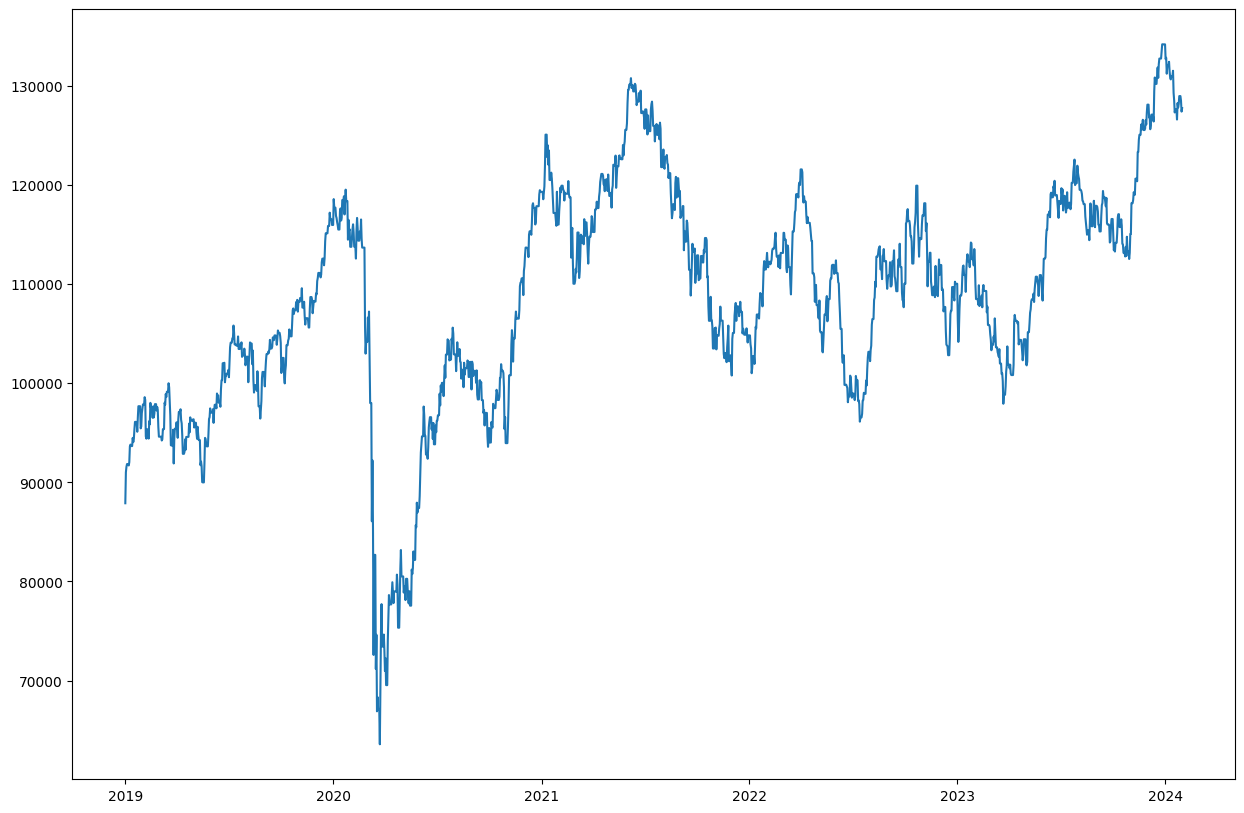

In [281]:
plt.figure(figsize=(15, 10))
plt.plot(df_close_last.index, df_close_last.Close)

Decomposição

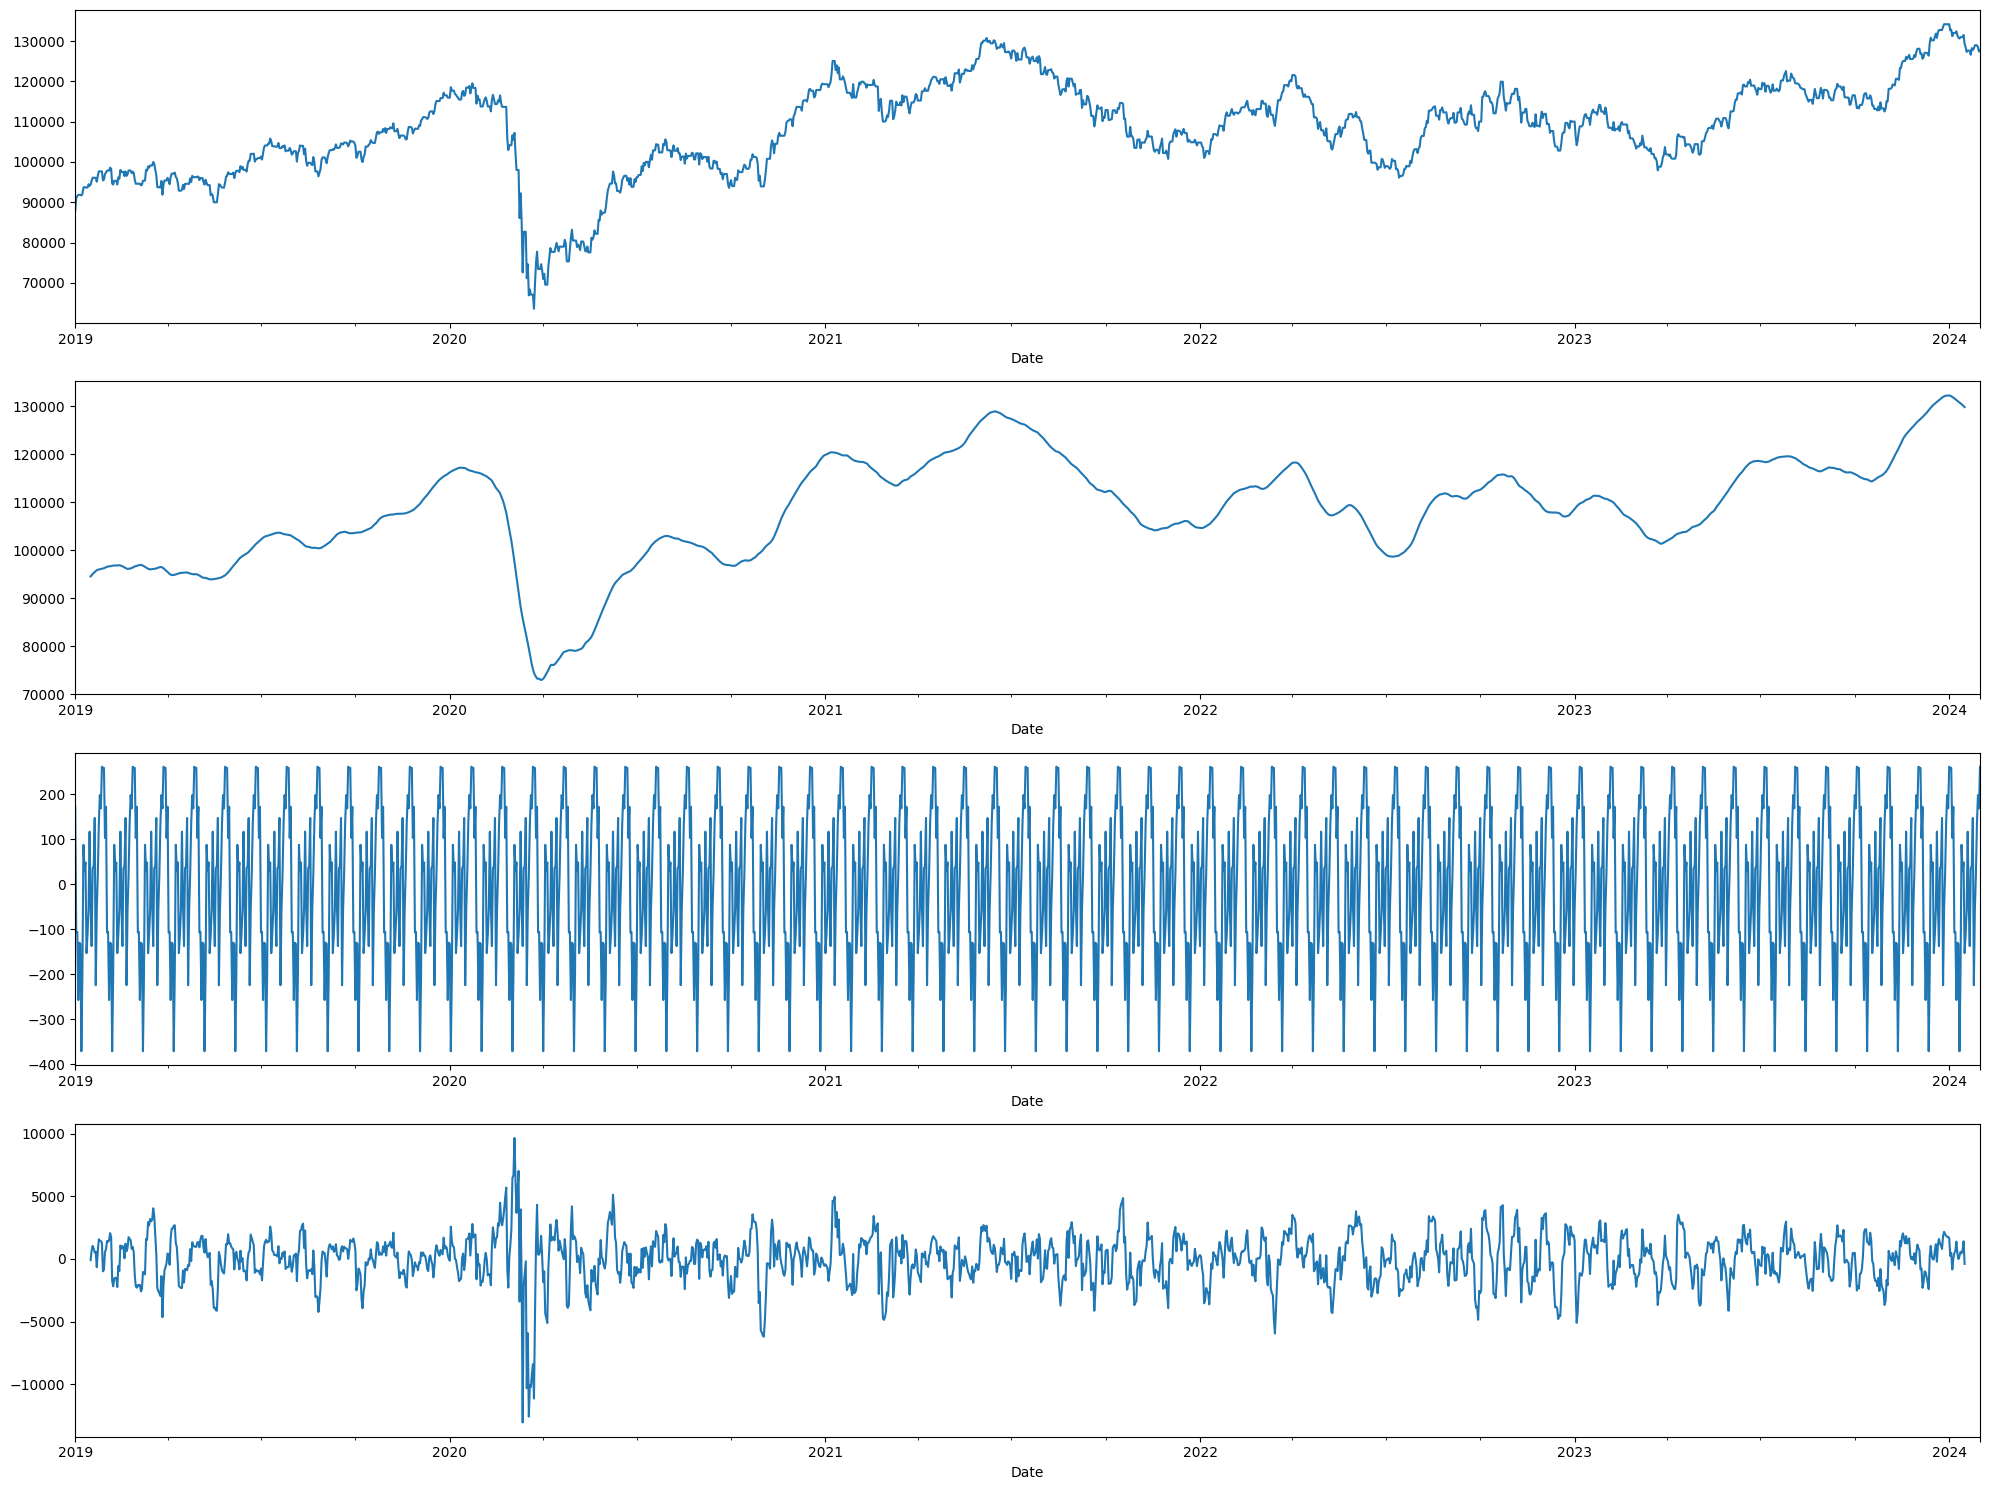

In [282]:
#Decomposicao
decomposition = seasonal_decompose(df_close_last , model='additive', period=30)

# Plota o resultado da decomposição
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,15))
decomposition.observed.plot(ax=ax1)
decomposition.trend.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.resid.plot(ax=ax4)
plt.tight_layout()

# Usa st.pyplot() para renderizar a figura no Streamlit
#st.pyplot(fig)


Plotagem de Rolling Statistics

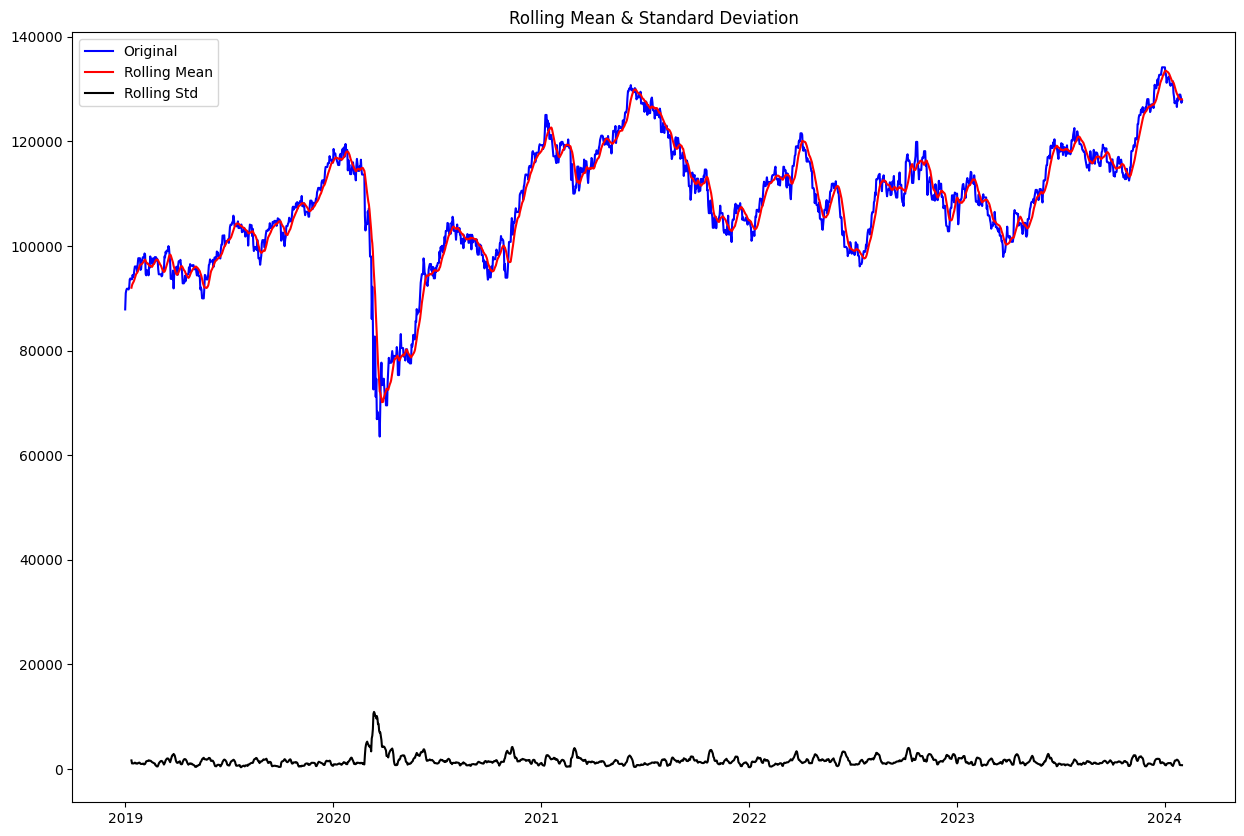

In [283]:
#Rolling statistics - Técnica Visual
rolmean = df_close_last.rolling(window=window).mean().dropna()
rolstd = df_close_last.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(df_close_last, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Embora a variação de desvio padrão seja pequena, a média está claramente aumentando com o tempo e isto não é uma característica de série estacionária. Além disso, a estatística de teste é muito mais do que os valores críticos. Note que os valores assinalados devem ser comparados e não os valores absolutos.

Dickey-Fuller teste

In [284]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_close_last, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -2.637870
p-value                           0.085420
#Lags Used                       12.000000
Number of Observations Used    1844.000000
Critical Value (1%)              -3.433901
Critical Value (5%)              -2.863109
Critical Value (10%)             -2.567605
dtype: float64


O teste de Dickey-Fuller é uma técnica estatística comumente usada para determinar se uma série temporal é estacionária ou não.

Estatística do teste: O valor da estatística do teste é -0.642799. Para que a série seja considerada estacionária, o valor da estatística do teste deve ser menor que os valores críticos.

Valor-p: O valor-p é 0.861015. Geralmente, se o valor-p é menor que 0.05, rejeitamos a hipótese nula e a série é considerada estacionária. Neste caso, o valor-p é significativamente maior que 0.05, indicando que a série não é estacionária.

Valores críticos: Os valores críticos para os níveis de significância de 1%, 5% e 10% são -3.431095, -2.861869 e -2.566945, respectivamente. A estatística do teste é maior que todos esses valores, o que reforça que a série não é estacionária.

Portanto, com base nesses resultados, a série temporal analisada não é estacionária. Você pode considerar diferenciar a série para torná-la estacionária e, em seguida, aplicar modelos de previsão adequados para séries temporais estacionárias.

## Transformar em estacionária

Uma das primeiras manobras para reduzir a tendência pode ser transformação. Por exemplo, neste caso, podemos ver claramente que existe uma tendência positiva significativa. Assim, podemos aplicar transformação que penaliza os valores maiores mais do que valores menores. 

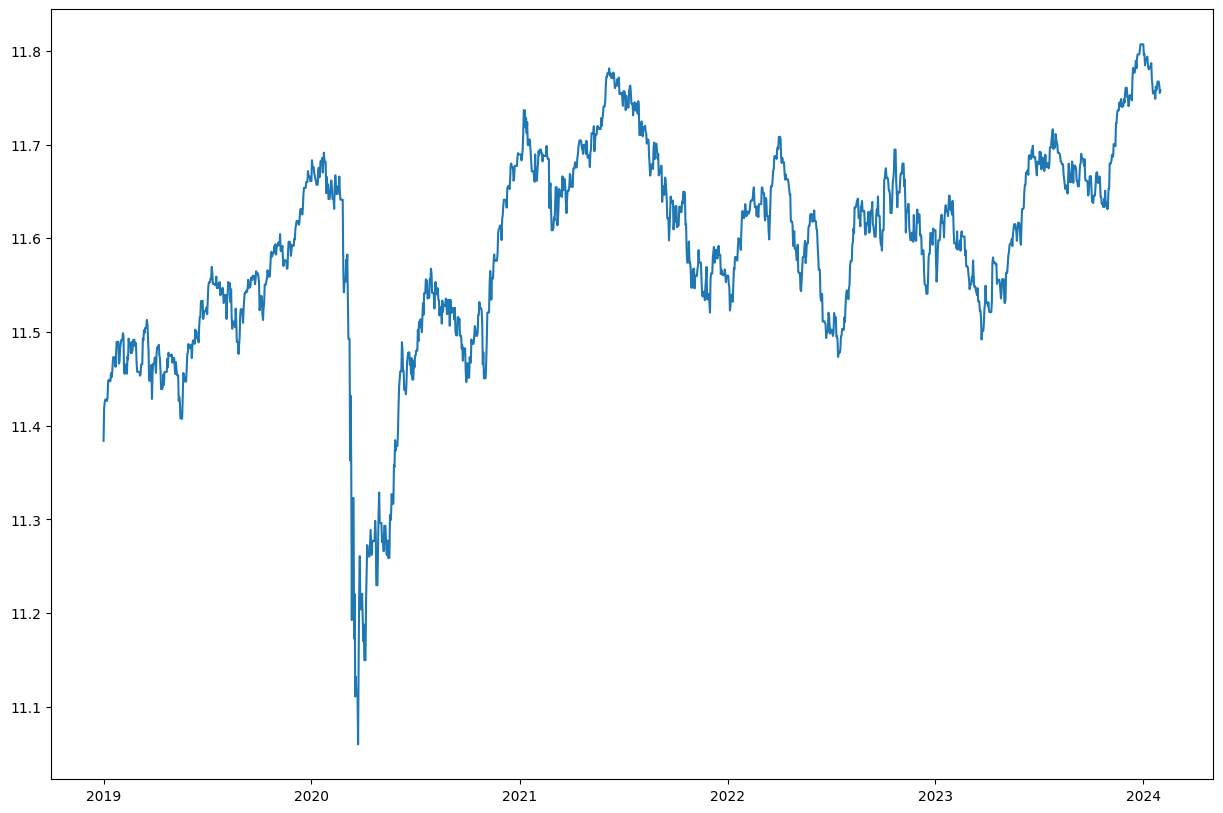

In [285]:
ts_log = np.log(df_close_last)
plt.figure(figsize=(15,10))
plt.plot(ts_log)

Média Móvel

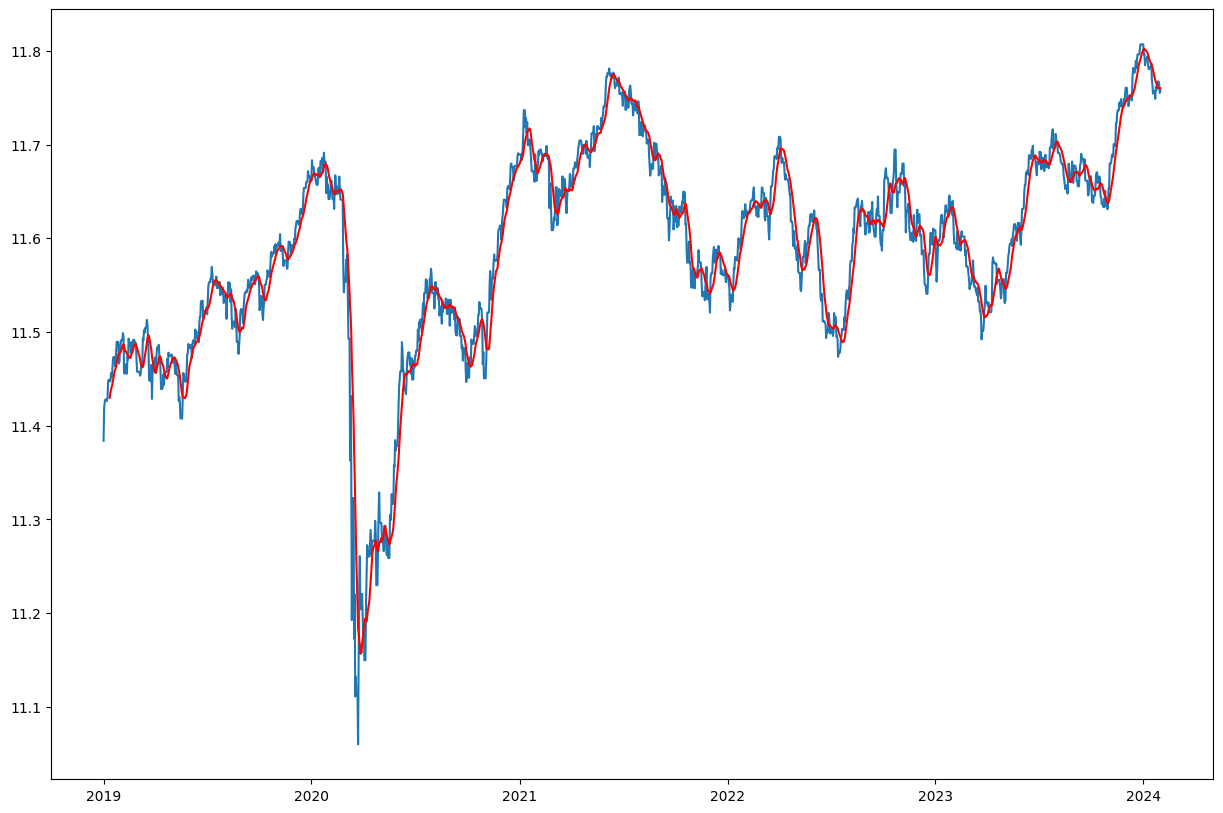

In [286]:
moving_avg = ts_log.rolling(window=window).mean()
plt.figure(figsize=(15,10))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

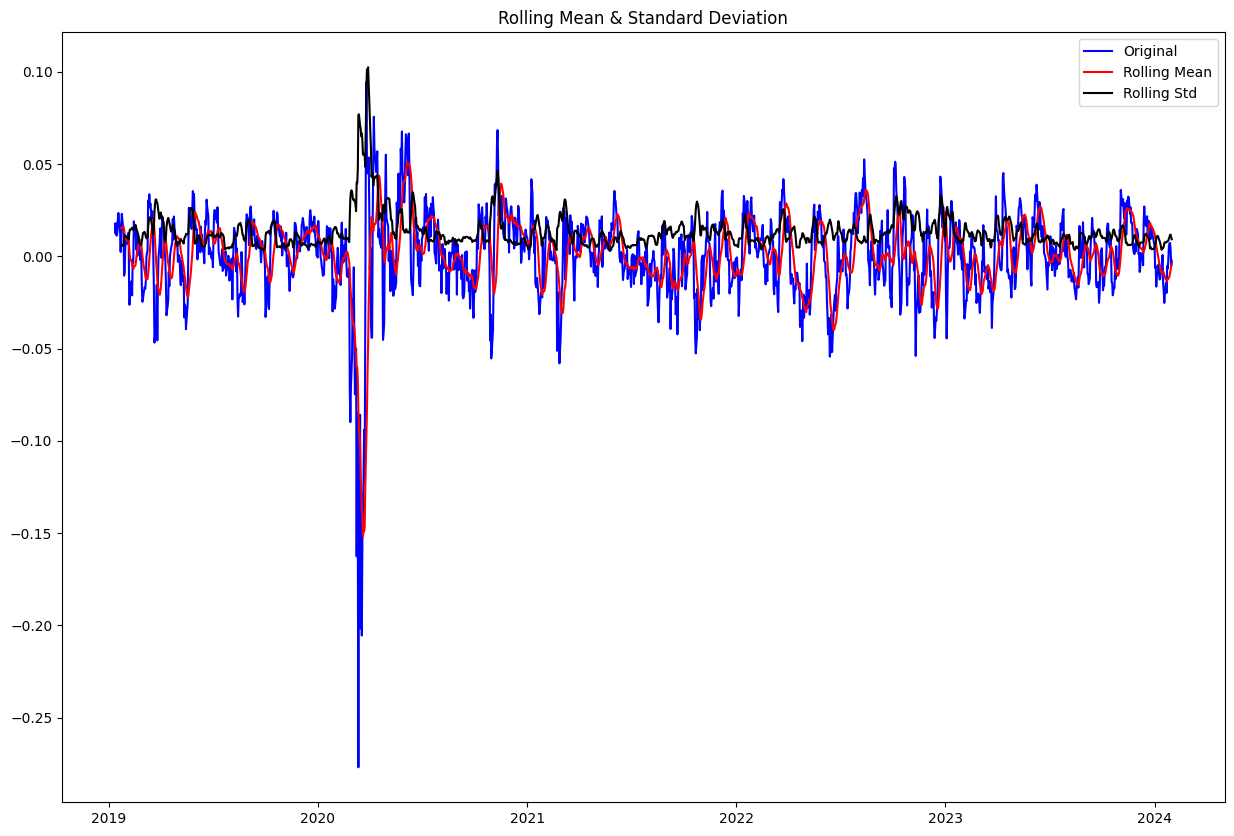

In [287]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

#Rolling statistics
rolmean = ts_log_moving_avg_diff.rolling(window=window).mean().dropna()
rolstd = ts_log_moving_avg_diff.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(ts_log_moving_avg_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [288]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log_moving_avg_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -8.733657e+00
p-value                        3.142301e-14
#Lags Used                     1.200000e+01
Number of Observations Used    1.833000e+03
Critical Value (1%)           -3.433923e+00
Critical Value (5%)           -2.863118e+00
Critical Value (10%)          -2.567610e+00
dtype: float64


Estatística do teste: O valor da estatística do teste é -3.062207. Para que a série seja considerada estacionária, o valor da estatística do teste deve ser menor que os valores críticos.

Valor-p: O valor-p é 0.029479. Geralmente, se o valor-p é menor que 0.05, rejeitamos a hipótese nula e a série é considerada estacionária. Neste caso, o valor-p é menor que 0.05, indicando que a série é estacionária.

Valores críticos: Os valores críticos para os níveis de significância de 1%, 5% e 10% são -3.434761, -2.863488 e -2.567807, respectivamente. A estatística do teste é maior que o valor crítico de 1%, mas menor que os valores críticos de 5% e 10%, o que indica que a série é estacionária a um nível de significância de 5% e 10%.

Portanto, com base nesses resultados, a série temporal analisada é estacionária a um nível de significância de 5% e 10%. Isso significa que a série não possui uma tendência ou sazonalidade sistemática.

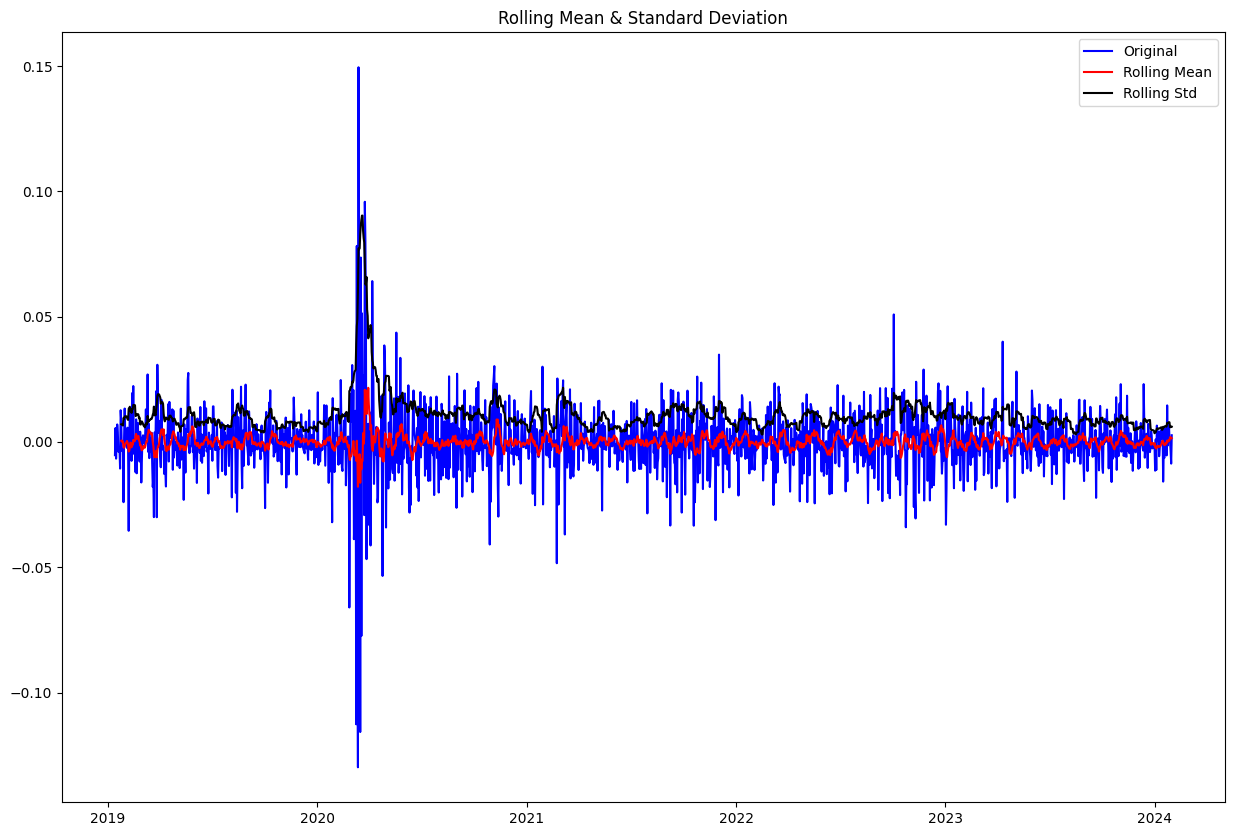

In [289]:
#Deixar mais estacionária - Derivada
df_diff = ts_log_moving_avg_diff.diff(1)

df_diff.dropna(inplace=True)

#Rolling statistics
rolmean = df_diff.rolling(window=window).mean().dropna()
rolstd = df_diff.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(df_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [290]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.397307e+01
p-value                        4.310098e-26
#Lags Used                     1.800000e+01
Number of Observations Used    1.826000e+03
Critical Value (1%)           -3.433936e+00
Critical Value (5%)           -2.863124e+00
Critical Value (10%)          -2.567613e+00
dtype: float64


Estatística do teste: O valor da estatística do teste é -9.195744. Para que a série seja considerada estacionária, o valor da estatística do teste deve ser menor que os valores críticos.

Valor-p: O valor-p é 2.065080e-15. Geralmente, se o valor-p é menor que 0.05, rejeitamos a hipótese nula e a série é considerada estacionária. Neste caso, o valor-p é significativamente menor que 0.05, indicando que a série é estacionária.

Valores críticos: Os valores críticos para os níveis de significância de 1%, 5% e 10% são -3.434761, -2.863488 e -2.567807, respectivamente. A estatística do teste é menor que todos esses valores, o que indica que a série é estacionária a todos esses níveis de significância.

Portanto, com base nesses resultados, a série temporal analisada é estacionária. Isso significa que a série não possui uma tendência ou sazonalidade sistemática.

## Modelos

AutoARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10559.797, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10587.659, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10589.450, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10561.796, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10589.222, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-10588.621, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-10588.817, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10591.449, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10591.222, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-10590.620, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10589.658, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 3.717 seconds
Test rmse:

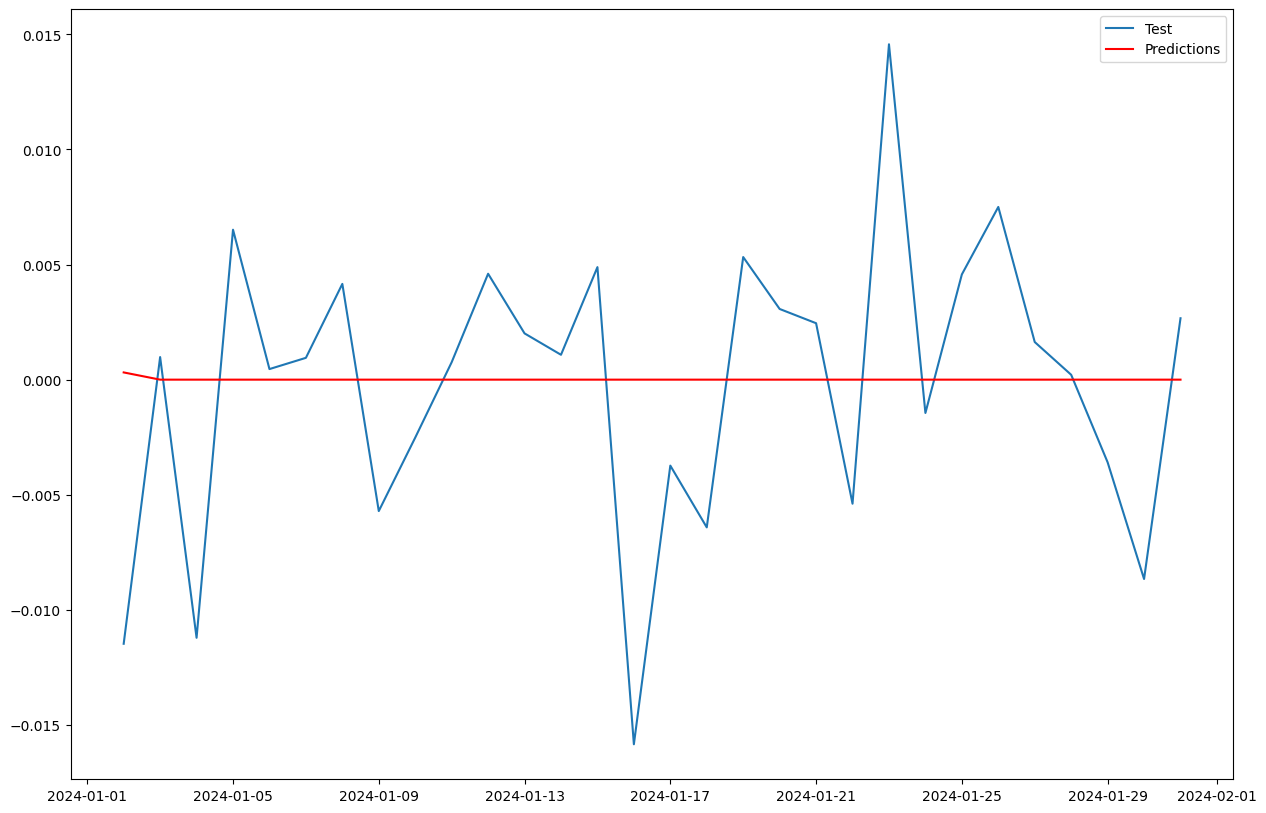

In [291]:
# Dividindo os dados em treino e teste
train = df_diff[df_diff.index <= '2024-01-01']
test = df_diff[df_diff.index > '2024-01-01']

# Treinando o modelo AutoARIMA
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

# Fazendo as previsões
predictions = model.predict(n_periods=len(test))

# Calculando a raiz do erro quadrático médio (RMSE)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test rmse: %.3f' % rmse)

mse = mean_squared_error(test, predictions)
print('Test mse: %.3f' % mse)

mae = mean_absolute_error(test, predictions)
print('Test mae: %.3f' % mae)

# Plotar os dados de teste e as previsões
plt.figure(figsize=(15,10))
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, color='red', label='Predictions')
plt.legend()
plt.show()

Prophet

## Conclusão